In [157]:
import stability_functions as sf
import numpy as np
from numpy.random import normal, seed, uniform
import os
import time
import sys
import rebound
import mr_forecast as mr
import numpy.random as rd
import radvel
import corner
import copy
import scipy
from scipy.optimize import curve_fit
import pandas as pd
from scipy import optimize
from radvel.plot import orbit_plots
import random
import dill
import sys
sys.path.append("../spock")
import dask.dataframe as dd
from celmech import Andoyer
from multiprocessing import Pool
# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
plt.style.use('paper.mplstyle')
# %matplotlib inline

# Generating systems and scores

In [161]:
sim_names = "K431/K431_uni_dens"
n = 10000
n_workers = 8

In [162]:
def pred(nsim):
    sim = rebound.SimulationArchive(sim_names + "_sa_%d.bin"%nsim)[0]
#     sim.move_to_com()
#     sim.integrator="whfast"
#     sim.dt = 0.07*sim.particles[1].P
#     prob=model.predict(sim)
    prob=model.predict(sim, copy=False)
    return prob

def get_k(row):
    sim = rebound.SimulationArchive(sim_names + "_sa_%d.bin"%(row[0]))[0]
#     print(sim)
    p2 = sim.particles[2]
    row['h'] = p2.e*np.sin(p2.pomega)
    row['k'] = p2.e*np.cos(p2.pomega)
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=5, k=1, i1=1, i2=2, average=False)
    row['Z12'] = avars.Z
    row['Zcom12'] = avars.Zcom
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=4, k=1, i1=2, i2=3, average=False)
    row['Z23'] = avars.Z
    row['Zcom23'] = avars.Zcom
    row['e1'] = sim.particles[1].e
    row['e2'] = sim.particles[2].e
    row['e3'] = sim.particles[3].e
    row['m1'] = sim.particles[1].m
    row['m2'] = sim.particles[2].m
    row['m3'] = sim.particles[3].m
    return row

pool = Pool(processes=n_workers, initializer=sf.init_process)

In [6]:
%%time

# getting basic r-m scaling laws from https://www.saraseager.com/research/exoplanet-interior-composition/
h_exp = (np.log(10) - np.log(1)) / (np.log(5.96) - np.log(3.05))
fe_exp = (np.log(10) - np.log(1)) / (np.log(1.4) - np.log(0.7))

for i in range(n):
    name = sim_names + "_sa_%d.bin"%i
    Ps = np.array([sf.a_normal(6.80252171, 7.931e-05, 7.931e-05), sf.a_normal(8.70337044, 9.645e-05, 9.645e-05), sf.a_normal(11.9216214, 0.0001182, 0.0001182)]) / sf.days_p_year
    As = Ps ** (2./3)
    es = np.array([0,0,0])
    bad_es = True
    e0_max = sf.max_e_inner(As[0], As[1])
    e1_max = np.minimum(sf.max_e_inner(As[1], As[2], es[2]), sf.max_e_outer(As[1], As[0]))  # ~0.15
    e2_max = sf.max_e_outer(As[2], As[1])
    while bad_es:
#         if use_log_e:
#             es = np.exp(rd.rand(3) * (np.log([e0_max, e1_max, e2_max]) - log_min_e) + log_min_e)
#         else:
        es = rd.rand(3) * np.array([e0_max, e1_max, e2_max])
        bad_es = not sf.check_es(As[0], es[0], As[1], es[1], As[2], es[2])
    rs = np.array([sf.a_normal(1.088, 0.146, 0.146), sf.a_normal(1.072, 0.171, 0.171), sf.a_normal(1.307, 0.160, 0.160)])
    lower = np.exp((np.log(rs) - np.log(3.05)) * h_exp)
    upper = np.exp((np.log(rs) - np.log(0.7)) * fe_exp)
    ms = lower + rd.rand(3) * (upper - lower)
    sim = sf.build_chosen_K431(ms, es, Ps)
    sf.replace_snapshot(sim, name)

CPU times: user 9.08 s, sys: 4.27 s, total: 13.3 s
Wall time: 2min 49s


In [139]:
%%time
nsim_list = np.arange(0,n)
res = pool.map(pred, nsim_list)

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. Th

KeyboardInterrupt: 

  File "/storage/home/cjg66/miniconda3/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/storage/home/cjg66/miniconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/storage/home/cjg66/miniconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [140]:
%%time
df1 = pd.DataFrame(nsim_list, columns=['sim'])
df1['k'] = 0.
df1['h'] = 0.
df1['Z12'] = 0.
df1['Zcom12'] = 0.
df1['Z23'] = 0.
df1['Zcom23'] = 0.
df1['e1'] = 0.
df1['e2'] = 0.
df1['e3'] = 0.
df1['m1'] = 0.
df1['m2'] = 0.
df1['m3'] = 0.
df1['probstability'] = res

dasklabels = dd.from_pandas(df1, npartitions=n_workers)
df = dasklabels.apply(get_k, axis=1, meta=df1).compute(scheduler='processes')

df.to_csv("K431_uni_dens.csv")

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


ValueError: Length of values does not match length of index

# Corner plots

In [171]:
df = pd.read_csv("K431_uni_dens.csv")
df["m1"] /= sf.earth_mass_2_solar_mass
df["m2"] /= sf.earth_mass_2_solar_mass
df["m3"] /= sf.earth_mass_2_solar_mass
df["m1+m2"] = df["m1"] + df["m2"]
df["m2+m3"] = df["m2"] + df["m3"]
df["total m"] = df["m1"] + df["m2"] + df["m3"]
scores = 2 * df["probstability"]
n = len(scores)
# effective sample size using eq 9.13 https://statweb.stanford.edu/~owen/mc/Ch-var-is.pdf
effective_sample_size = n * np.mean(scores) ** 2 / np.mean(scores ** 2)
print(effective_sample_size)
print(n)
print(effective_sample_size / n)

806.8470104677044
10000
0.08068470104677045


In [172]:
def quantile_1D(data, weights, quantile):
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    Sn =  np.array(np.cumsum(sorted_weights))
    Pn = (Sn-0.5*sorted_weights)/Sn[-1]
    return np.interp(quantile, Pn, sorted_data)

In [211]:
notebook_name = "K431_density_"
system_name = "K431 "

def create_hist(label, show_quantiles=True, label2="", xlabel=""):
    if label2 == "":
        label2=label
    plt.figure(figsize=(8,4.5))
    n_bins=50
    plt.hist(df[label], density=True, bins=n_bins, alpha=0.6)
    plt.hist(df[label], density=True, bins=n_bins, alpha=0.6, weights=df["probstability"])
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True)
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True, weights=df["probstability"])
    plt.title(system_name + label2, size=30)
    plt.xlabel(xlabel, size=20)
    left, right = plt.xlim()  # return the current xlim
    left = 0
    plt.xlim(left, right)
    print()
    std1 = np.std(df[label])
    weight_mean = np.average(df[label], weights=df["probstability"])
    std2 = np.sqrt(np.average((df[label]-weight_mean)**2, weights=df["probstability"]))
    print("std before: %f"%(std1))
    print("std after: %f"%(std2))
    print("factor of %f smaller"%(std1/std2))
    
    quant1 = np.quantile(df[label], 0.16)
    quant2 = np.quantile(df[label], 0.84)
    quant3 = quantile_1D(df[label], df["probstability"], 0.16)
    quant4 = quantile_1D(df[label], df["probstability"], 0.84)
    sigma1 = (quant2 - quant1) / 2
    sigma2 = (quant4 - quant3) / 2
    print("\"sigma\" before: %f"%(sigma1))
    print("\"sigma\" after: %f"%(sigma2))
    print("factor of %f smaller"%(sigma1/sigma2))
    if show_quantiles:
        plt.axvline(x=quant1, color="C0")
        plt.axvline(x=quant2, color="C0")
        plt.axvline(x=quant3, color="C1")
        plt.axvline(x=quant4, color="C1")
        
        kde = scipy.stats.gaussian_kde(df[label])
        xs = np.linspace(left, right, 1000)
        ys = kde(xs) + kde(-xs)
        popt1, pcov = curve_fit(gaussian, xs, ys, [0.3, 1, 3])
        print("Gaussian fit std before: ", popt1[2])
#         plt.plot(xs, ys, color="C0")
        plt.plot(xs, gaussian(xs, *popt1), color="C0")
        
        kde = scipy.stats.gaussian_kde(df[label], weights=df["probstability"])
        ys = kde(xs) + kde(-xs)
        popt2, pcov = curve_fit(gaussian, xs, ys, [0.3, 1, 3])
        print("Gaussian fit std after: ", popt2[2])
#         plt.plot(xs, ys, color="C1")
        plt.plot(xs, gaussian(xs, *popt2), color="C1")
        
        print("factor of %f smaller"%(popt1[2]/popt2[2]))
        
    plt.savefig(notebook_name + label + "_hist.png", bbox_inches="tight")

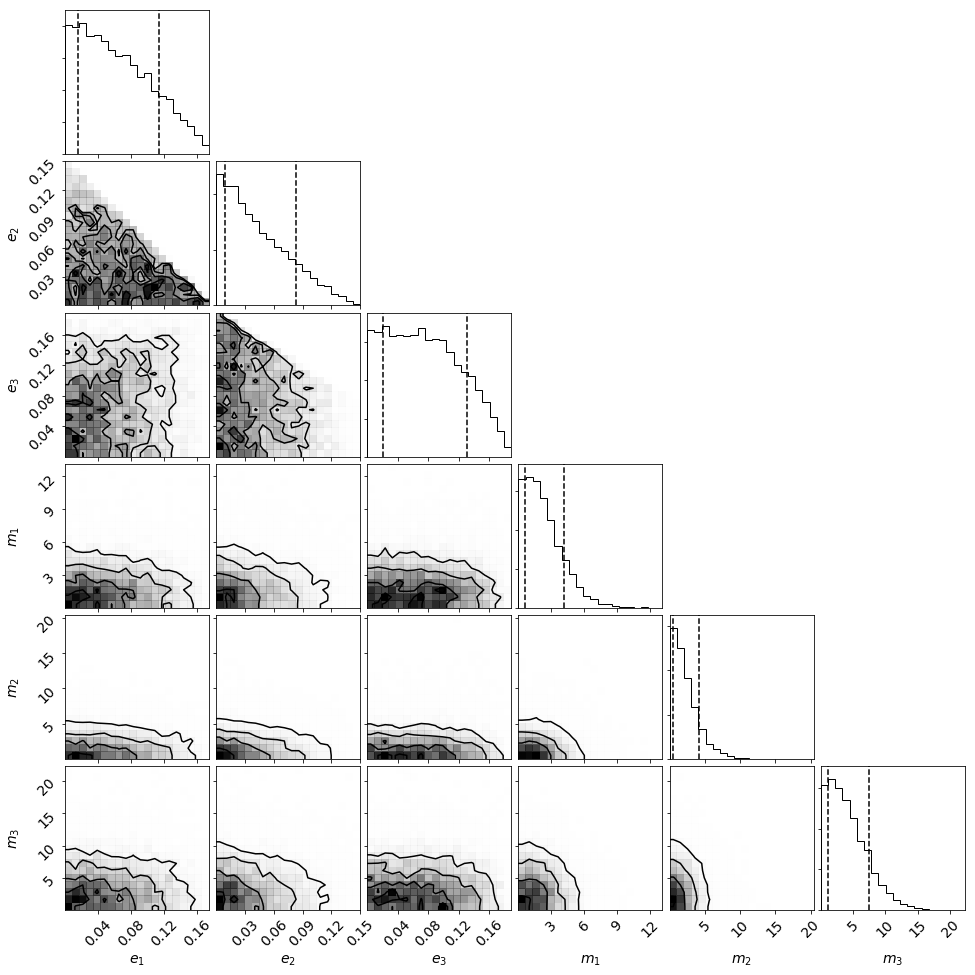

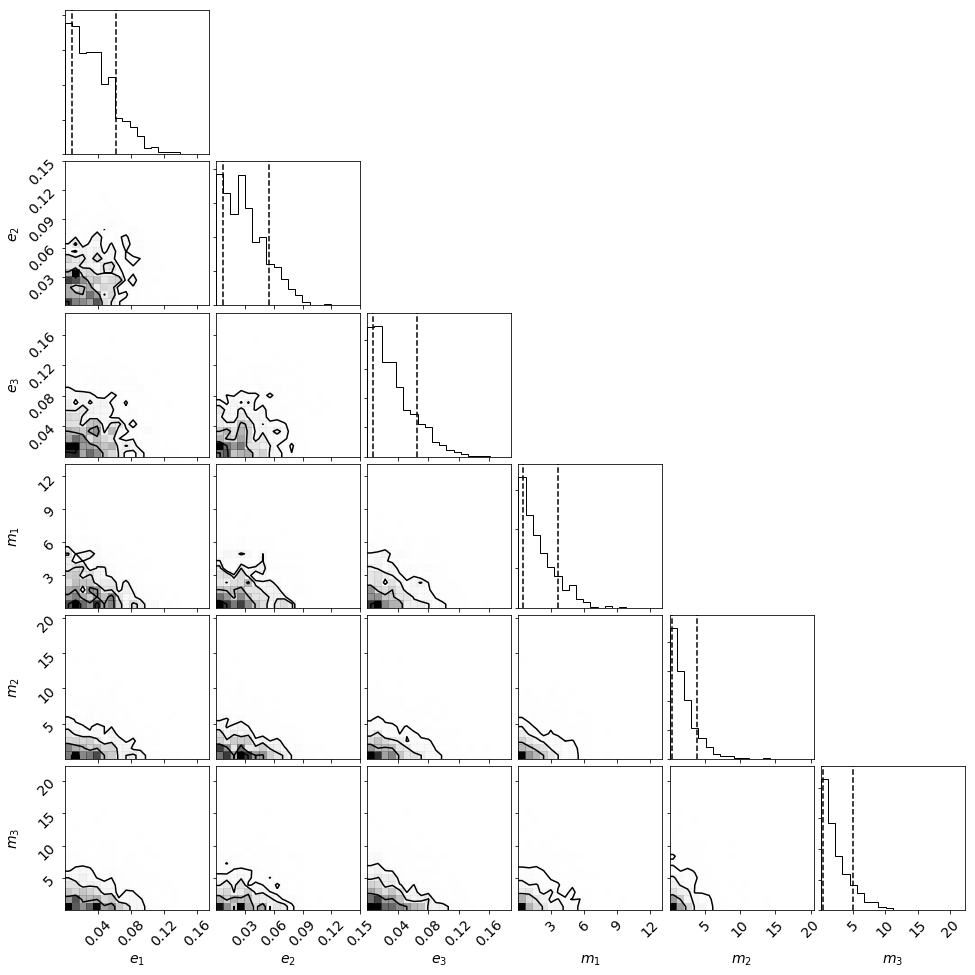

In [174]:
labels = ["e1","e2", "e3", "m1", "m2", "m3"]
labels2 = [r"$e_1$", r"$e_2$", r"$e_3$", r"$m_1$", r"$m_2$", r"$m_3$"]
fig = corner.corner(df[labels], labels=labels2, quantiles=[0.15,0.85], plot_datapoints=False)
# plt.savefig(notebook_name + "physical_corner_noweight.png", bbox_inches="tight")
fig = corner.corner(df[labels], labels=labels2, quantiles=[0.15,0.85], plot_datapoints=False, weights=df["probstability"])
# plt.savefig(notebook_name + "physical_corner_weight.png", bbox_inches="tight")

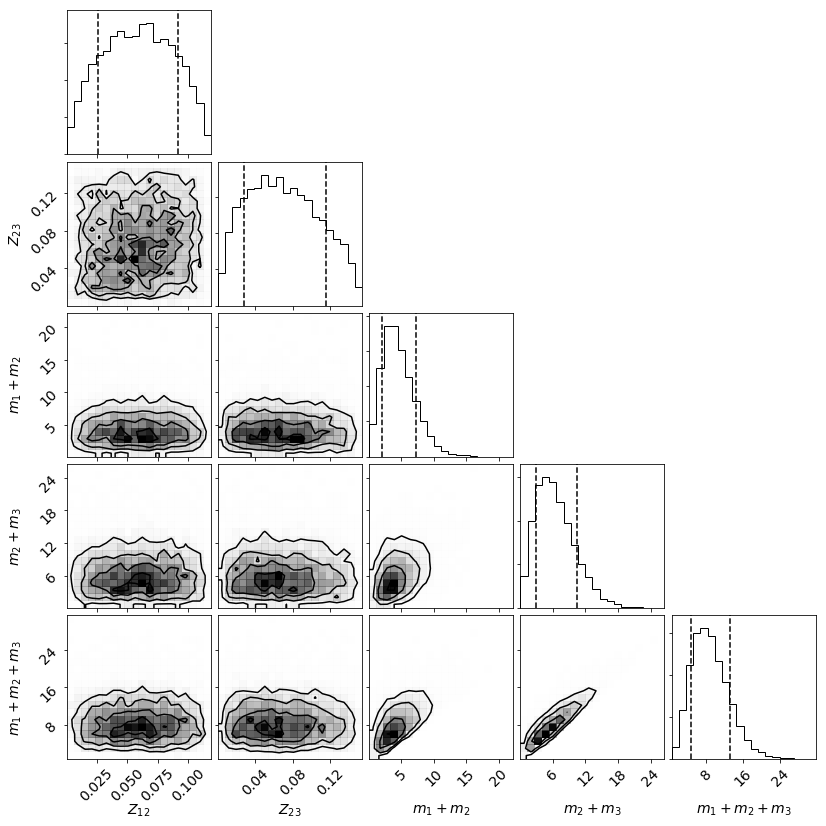

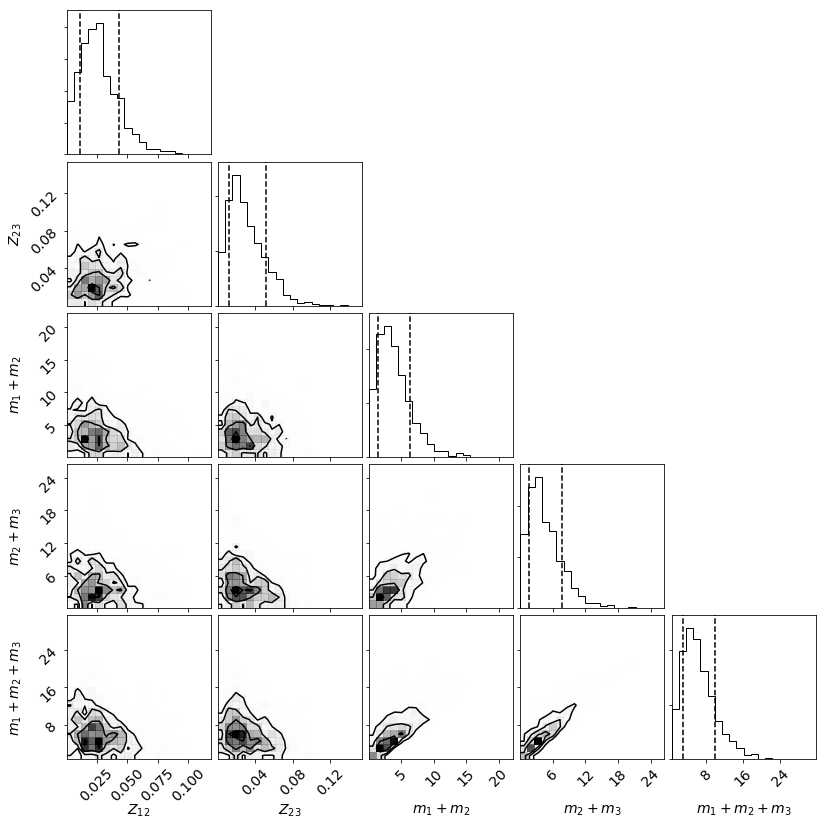

In [175]:
labels = ["Z12", "Z23", "m1+m2", "m2+m3", "total m"]
labels2 = [r"$Z_{12}$", r"$Z_{23}$", r"$m_1 + m_2$", r"$m_2 + m_3$", r"$m_1 + m_2 + m_3$"]
fig = corner.corner(df[labels], labels=labels2, quantiles=[0.15,0.85], plot_datapoints=False)
plt.savefig(notebook_name + "param_corner_noweight.png", bbox_inches="tight")
fig = corner.corner(df[labels], labels=labels2, quantiles=[0.15,0.85], plot_datapoints=False, weights=df["probstability"])
plt.savefig(notebook_name + "param_corner_weight.png", bbox_inches="tight")


std before: 1.749447
std after: 1.569453
factor of 1.114686 smaller
"sigma" before: 1.699540
"sigma" after: 1.536579
factor of 1.106054 smaller
Gaussian fit std before:  2.4535597413834886
Gaussian fit std after:  3.691318492370617
factor of 0.664684 smaller

std before: 1.941765
std after: 1.962992
factor of 0.989186 smaller
"sigma" before: 1.719318
"sigma" after: 1.687904
factor of 1.018611 smaller
Gaussian fit std before:  2.86411337865022
Gaussian fit std after:  4.056443864487239
factor of 0.706065 smaller

std before: 3.102275
std after: 2.318318
factor of 1.338158 smaller
"sigma" before: 3.065462
"sigma" after: 2.104695
factor of 1.456488 smaller
Gaussian fit std before:  4.56176683389485
Gaussian fit std after:  7.824325460453781
factor of 0.583024 smaller


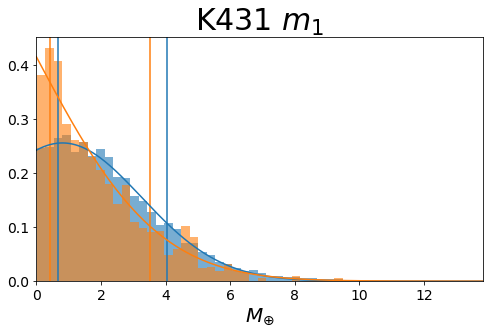

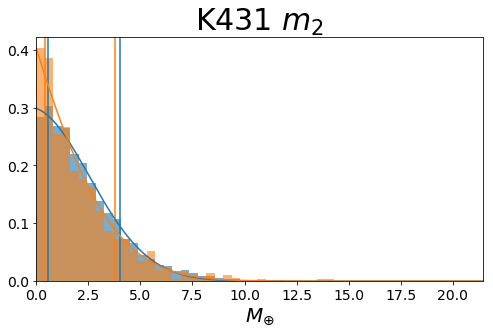

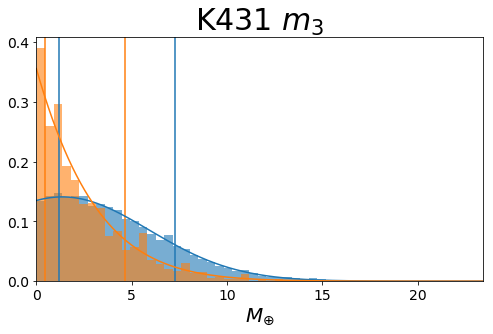

In [212]:
create_hist("m1", label2=r"$m_1$", xlabel=r"$M_{\oplus}$")
create_hist("m2", label2=r"$m_2$", xlabel=r"$M_{\oplus}$")
create_hist("m3", label2=r"$m_3$", xlabel=r"$M_{\oplus}$")


std before: 2.602214
std after: 2.569432
factor of 1.012758 smaller
"sigma" before: 2.476197
"sigma" after: 2.391890
factor of 1.035247 smaller
Gaussian fit std before:  2.4895444503612367
Gaussian fit std after:  2.630082800860704
factor of 0.946565 smaller

std before: 3.671563
std after: 3.082468
factor of 1.191112 smaller
"sigma" before: 3.615109
"sigma" after: 2.899119
factor of 1.246968 smaller
Gaussian fit std before:  3.7535187722997883
Gaussian fit std after:  3.55341419708846
factor of 1.056313 smaller

std before: 4.039439
std after: 3.597514
factor of 1.122842 smaller
"sigma" before: 3.999332
"sigma" after: 3.363178
factor of 1.189153 smaller
Gaussian fit std before:  -3.9873021785141853
Gaussian fit std after:  3.449789857068671
factor of -1.155810 smaller


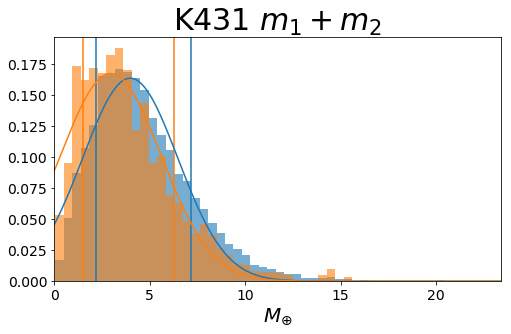

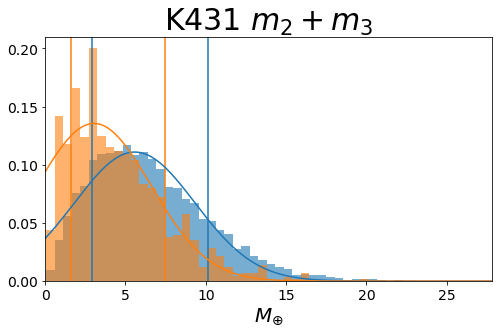

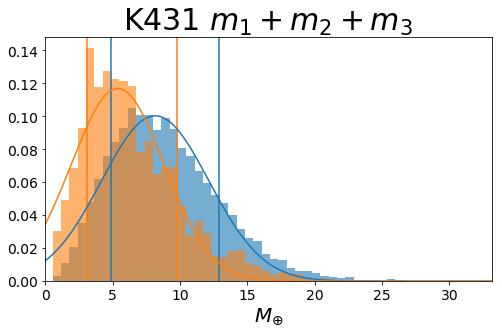

In [213]:
create_hist("m1+m2", label2=r"$m_1 + m_2$", xlabel=r"$M_{\oplus}$")
create_hist("m2+m3", label2=r"$m_2 + m_3$", xlabel=r"$M_{\oplus}$")
create_hist("total m", label2=r"$m_1 + m_2 + m_3$", xlabel=r"$M_{\oplus}$")


std before: 0.042757
std after: 0.026152
factor of 1.634945 smaller
"sigma" before: 0.047195
"sigma" after: 0.026023
factor of 1.813563 smaller

std before: 0.033056
std after: 0.021921
factor of 1.507960 smaller
"sigma" before: 0.035163
"sigma" after: 0.022668
factor of 1.551239 smaller

std before: 0.046801
std after: 0.027674
factor of 1.691146 smaller
"sigma" before: 0.053053
"sigma" after: 0.028039
factor of 1.892092 smaller


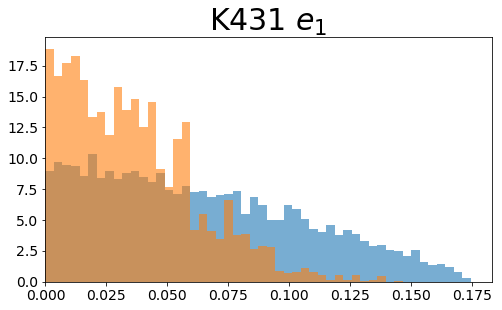

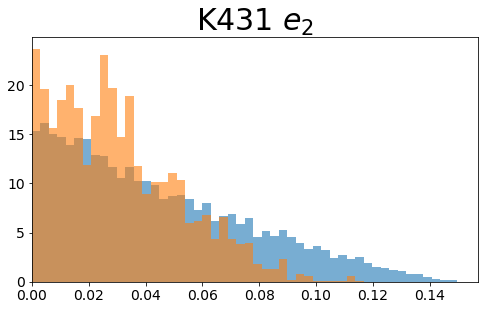

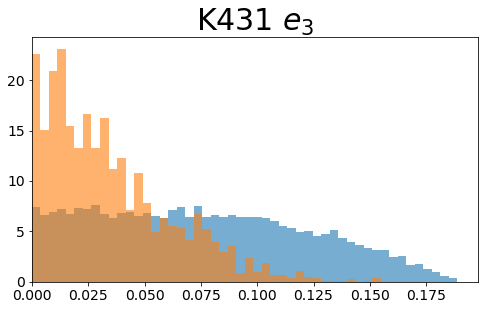

In [198]:
create_hist("e1", show_quantiles=False, label2=r"$e_1$")
create_hist("e2", show_quantiles=False, label2=r"$e_2$")
create_hist("e3", show_quantiles=False, label2=r"$e_3$")


std before: 0.028275
std after: 0.016156
factor of 1.750125 smaller
"sigma" before: 0.031685
"sigma" after: 0.015523
factor of 2.041135 smaller

std before: 0.037310
std after: 0.019357
factor of 1.927417 smaller
"sigma" before: 0.042030
"sigma" after: 0.019055
factor of 2.205730 smaller


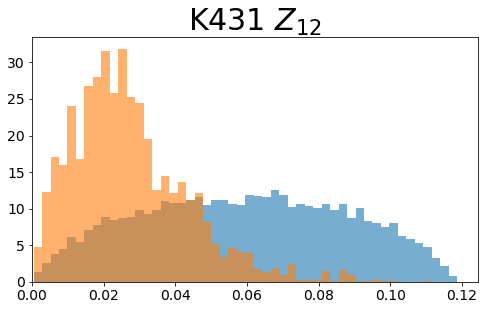

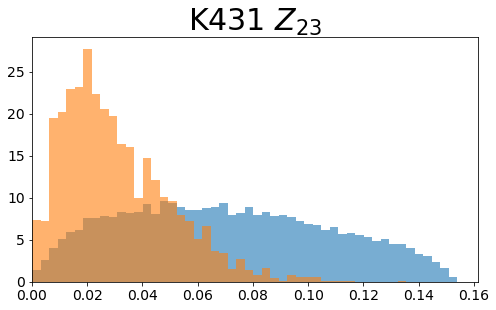

In [199]:
create_hist("Z12", show_quantiles=False, label2=r"$Z_{12}$")
create_hist("Z23", show_quantiles=False, label2=r"$Z_{23}$")

# RV constraints

In [2]:
seconds_p_day = 86400
days_p_year = 365.25
meters_p_AU = 149597870700
earth_mass_2_solar_mass = 0.000003003
year_p_reboundtime = 1 / (2 * np.pi)

# Convenient function for plotting fits
def plot_results(like):
    ti = np.linspace(np.min(t), np.max(t), 1000)
    fig = plt.gcf()
    plt.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plt.plot(ti, like.model(ti))
    plt.xlabel('Time')
    plt.ylabel('RV')
    plt.draw()

In [3]:
sim_nums = np.array([10, 82, 199, 55, 101, 84, 127, 2050, 261, 100, 190, 218])
sim_num = sim_nums[0]

system = "K431"
out_dir = os.getcwd()+"/output/"+system+"/"
name = out_dir+system+"_start_"+str(sim_num)+".bin"

print("simulation archive:", name)
sim = rebound.SimulationArchive(name)[0]

simulation archive: /storage/work/c/cjg66/Dan_research/Stability-Priors/output/K431/K431_start_10.bin


In [110]:
seed(3)
n_meas = 50
t = 0.75 * np.sort(rd.rand(n_meas))
syn_rv = sf.rebound_rvs(t, rebound.SimulationArchive(name)[0])
ti = np.linspace(np.min(t), np.max(t), 1000)
syn_rv_no_noise = sf.rebound_rvs(ti, rebound.SimulationArchive(name)[0])
t *= days_p_year
ti *= days_p_year

errs = np.array([30, 10, 3, 1, 0.3, 0.1, 0.03, 0.01])
if sys.argv[1] != "-f":
    err_ind = int(sys.argv[1])
else:
    err_ind = 0
errvel = errs[err_ind]

jitter = 0.0
stellar = jitter * rd.randn(n_meas)

syn_rv += syn_rv + rd.randn(n_meas) * errvel + stellar
print("jitter value:", jitter)

jitter value: 0.0


In [111]:
Ps = np.array([sim.particles[i+1].P for i in range(3)]) * (days_p_year * year_p_reboundtime)
es = np.array([sim.particles[i+1].e for i in range(3)])
Mstar = sim.particles[0].m
ms = np.array([sim.particles[i+1].m for i in range(3)]) / earth_mass_2_solar_mass
incs = np.array([sim.particles[i+1].inc for i in range(3)]) + np.pi/2
og_Ks = sf.VSA(Ps / days_p_year, Mstar, ms, es, incs)
Ks = np.copy(og_Ks)

# omegas = np.pi * 2 * np.random.uniform(size=3)
omegas = np.array([sim.particles[i+1].omega for i in range(3)])
print("og Ks:", og_Ks)
print("initial Ks:", Ks)

og Ks: [0.29795106 0.47920105 1.04729092]
initial Ks: [0.29795106 0.47920105 1.04729092]


In [112]:
params = radvel.Parameters(3, basis='per tc secosw sesinw k')
params['per1'] = radvel.Parameter(value=Ps[0])
params['tc1'] = radvel.Parameter(value= 2454971.03562)
params['secosw1'] = radvel.Parameter(value=np.sqrt(es[0]) * np.cos(omegas[0]))
params['sesinw1'] = radvel.Parameter(value=np.sqrt(es[0]) * np.sin(omegas[0]))
params['k1'] = radvel.Parameter(value=Ks[0])

params['per2'] = radvel.Parameter(value=Ps[1])
params['tc2'] = radvel.Parameter(value=2454973.1707)
params['secosw2'] = radvel.Parameter(value=np.sqrt(es[1]) * np.cos(omegas[1]))
params['sesinw2'] = radvel.Parameter(value=np.sqrt(es[1]) * np.sin(omegas[1]))
params['k2'] = radvel.Parameter(value=Ks[1])

params['per3'] = radvel.Parameter(value=Ps[2])
params['tc3'] = radvel.Parameter(value=2454970.47509)
params['secosw3'] = radvel.Parameter(value=np.sqrt(es[2]) * np.cos(omegas[2]))
params['sesinw3'] = radvel.Parameter(value=np.sqrt(es[2]) * np.sin(omegas[2]))
params['k3'] = radvel.Parameter(value=Ks[2])

# params['dvdt'] = radvel.Parameter(value=0)
# params['curv'] = radvel.Parameter(value=0)

rv_mod = radvel.RVModel(params)

In [113]:
like_syn = radvel.likelihood.RVLikelihood(rv_mod, t, syn_rv, np.zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=jitter)

like_syn.params['jit'].vary = False # Don't vary jitter
# like_syn.params['k1'].vary = False # Don't vary period
# like_syn.params['k2'].vary = False # Don't vary period
# like_syn.params['k3'].vary = False # Don't vary period
# like_syn.params['per1'].vary = False # Don't vary period
# like_syn.params['per2'].vary = False # Don't vary period
# like_syn.params['per3'].vary = False # Don't vary period
like_syn.params['dvdt'].vary = False # Don't vary dvdt
like_syn.params['curv'].vary = False # Don't vary curvature
like_syn.params['gamma'].vary = False # Don't vary gamma
print(like_syn)

parameter                     value      vary
per1                        6.80249       True
tc1                         4971.04       True
secosw1                   -0.110573       True
sesinw1                  -0.0103887       True
k1                         0.297951       True
per2                        8.70325       True
tc2                         4973.17       True
secosw2                  -0.0882106       True
sesinw2                   0.0495855       True
k2                         0.479201       True
per3                        11.9216       True
tc3                         4970.48       True
secosw3                   0.0262267       True
sesinw3                  -0.0580268       True
k3                          1.04729       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                               0      False



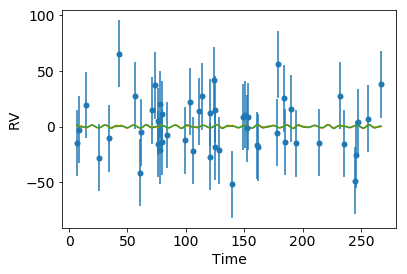

In [114]:
# Plot initial model
plot_results(like_syn)
plt.plot(ti, syn_rv_no_noise)
# plt.savefig("figs/beforeMLE_%d.png"%err_ind, bbox_inches="tight")
# plt.close(fig="all")

parameter                     value      vary
per1                        6.80267       True
tc1                         4971.04       True
secosw1                   -0.110573       True
sesinw1                  -0.0103887       True
k1                         0.297951       True
per2                        8.70311       True
tc2                         4973.17       True
secosw2                  -0.0882106       True
sesinw2                   0.0495855       True
k2                         0.479201       True
per3                        11.9217       True
tc3                         4970.48       True
secosw3                   0.0262267       True
sesinw3                  -0.0580268       True
k3                          1.04729       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                               0      False



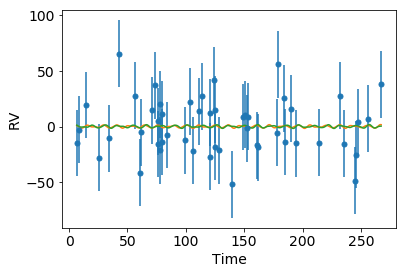

In [116]:
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B')
# print(res)
print(like_syn)
plot_results(like_syn) # plot best fit model
plt.plot(ti, syn_rv_no_noise)
# plt.savefig("figs/afterMLE_%d.png"%err_ind, bbox_inches="tight")

In [125]:
df = pd.read_csv("K431_uni_dens.csv")
df["m1"] /= sf.earth_mass_2_solar_mass
df["m2"] /= sf.earth_mass_2_solar_mass
df["m3"] /= sf.earth_mass_2_solar_mass
df["m1+m2"] = df["m1"] + df["m2"]
df["m2+m3"] = df["m2"] + df["m3"]
df["total m"] = df["m1"] + df["m2"] + df["m3"]
scores = 2 * df["probstability"]
n = len(scores)

# effective sample size using eq 9.13 https://statweb.stanford.edu/~owen/mc/Ch-var-is.pdf
effective_sample_size = n * np.mean(scores) ** 2 / np.mean(scores ** 2)
print(effective_sample_size)
print(n)
print(effective_sample_size / n)

post = radvel.posterior.Posterior(like_syn)

post.priors += [radvel.prior.Gaussian("per1", 6.80252171, 7.931e-05)]
post.priors += [radvel.prior.Gaussian("per2", 8.70337044, 9.645e-05)]
post.priors += [radvel.prior.Gaussian("per3", 11.9216214, 0.0001182)]

labels = [k for k in post.params.keys() if post.params[k].vary]
print(labels)

prior_ms = [scipy.stats.gaussian_kde(df["m1"]), scipy.stats.gaussian_kde(df["m2"]), scipy.stats.gaussian_kde(df["m3"])]
prior_es = [scipy.stats.gaussian_kde(df["e1"]), scipy.stats.gaussian_kde(df["e2"]), scipy.stats.gaussian_kde(df["e3"])]

inds = np.sort(np.random.choice(range(len(df)), size=4000, replace=False))
prior_ms_small = [scipy.stats.gaussian_kde(df["m1"][inds]), scipy.stats.gaussian_kde(df["m2"][inds]), scipy.stats.gaussian_kde(df["m3"][inds])]
prior_es_small = [scipy.stats.gaussian_kde(df["e1"][inds]), scipy.stats.gaussian_kde(df["e2"][inds]), scipy.stats.gaussian_kde(df["e3"][inds])]

def myPriorFunc(inp_list):
    
    prob = 1
    
    for i in range(3):
        secosw = inp_list[labels.index("secosw%d"%(i+1))]
        sesinw = inp_list[labels.index("sesinw%d"%(i+1))]
        e = secosw * secosw + sesinw * sesinw
        if e > 1:
            return -np.inf
        P = inp_list[labels.index("per%d"%(i+1))] / sf.days_p_year
        k = inp_list[labels.index("k%d"%(i+1))]
        m = sf.mass_from_VSA(P, Mstar, k, e, np.pi/2)
        prob *= (prior_ms_small[i](m) + prior_ms_small[i](-m)) * (prior_es_small[i](e) + prior_es_small[i](-e))
    
    return np.log(prob)

post.priors += [radvel.prior.UserDefinedPrior(labels, myPriorFunc, 'Eccentricty and mass prior')]
# post.priors += [radvel.prior.EccentricityPrior(3)]

print("Before fitting\n")
print(post)

806.8470104677044
10000
0.08068470104677045
['per1', 'tc1', 'secosw1', 'sesinw1', 'k1', 'per2', 'tc2', 'secosw2', 'sesinw2', 'k2', 'per3', 'tc3', 'secosw3', 'sesinw3', 'k3']
Before fitting

parameter                     value      vary
per1                        6.80267       True
tc1                         4971.04       True
secosw1                   -0.110573       True
sesinw1                  -0.0103887       True
k1                         0.297951       True
per2                        8.70311       True
tc2                         4973.17       True
secosw2                  -0.0882106       True
sesinw2                   0.0495855       True
k2                         0.479201       True
per3                        11.9217       True
tc3                         4970.48       True
secosw3                   0.0262267       True
sesinw3                  -0.0580268       True
k3                          1.04729       True
dvdt                              0      False
curv        

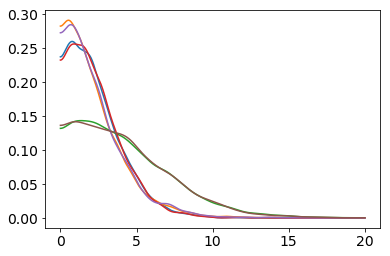

In [126]:
xs = np.linspace(0, 20, 1000)
plt.plot(xs, prior_ms[0](xs) + prior_ms[0](-xs))
plt.plot(xs, prior_ms[1](xs) + prior_ms[1](-xs))
plt.plot(xs, prior_ms[2](xs) + prior_ms[2](-xs))
plt.plot(xs, prior_ms_small[0](xs) + prior_ms_small[0](-xs))
plt.plot(xs, prior_ms_small[1](xs) + prior_ms_small[1](-xs))
plt.plot(xs, prior_ms_small[2](xs) + prior_ms_small[2](-xs))

In [127]:
# res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='L-BFGS-B')
# plot_results(post.likelihood)
# plt.savefig("afterpriors_%d.png"%err_ind, bbox_inches="tight")
print("After fitting\n")
print(post)

After fitting

parameter                     value      vary
per1                        6.80248       True
tc1                         4971.04       True
secosw1                   -0.110573       True
sesinw1                  -0.0103887       True
k1                         0.297951       True
per2                        8.70333       True
tc2                         4973.17       True
secosw2                  -0.0882106       True
sesinw2                   0.0495855       True
k2                         0.479201       True
per3                        11.9216       True
tc3                         4970.48       True
secosw3                   0.0262267       True
sesinw3                  -0.0580268       True
k3                          1.04729       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                               0      False

Priors
------
Gaussian prior on per1, mu=6.80

(<Figure size 540x1018.29 with 6 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fa6d213ba90>])

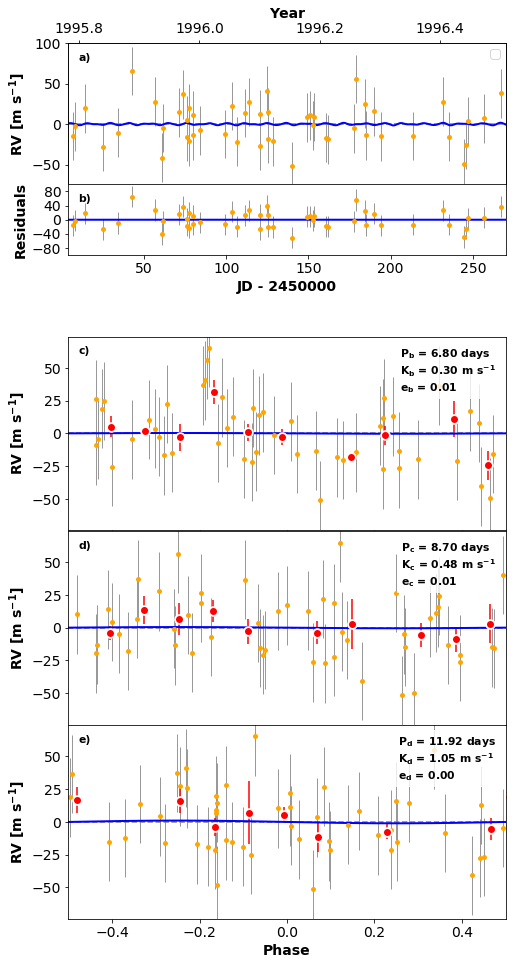

In [128]:
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()
# plt.show()
# plt.savefig("figs/afterpriors_%d.png"%err_ind, bbox_inches="tight")
# plt.close(fig="all")

In [129]:
%%time
# df = radvel.mcmc(post) # amount of steps = nrun * 8 * nwalkers ?
df3 = radvel.mcmc(post, nrun=1000) # amount of steps = nrun * 8 * nwalkers ?, default nrun is 10000, default nwalkers is 50?
# df.to_pickle("mcmc/mcmc_K431_%d.pkl"%err_ind)

20000/400000 (5.0%) steps complete; Running 2111.15 steps/s; Mean acceptance rate = 41.2%; Min Tz = 4717.1; Max G-R = 1.006      
Discarding burn-in now that the chains are marginally well-mixed

160000/400000 (40.0%) steps complete; Running 2070.21 steps/s; Mean acceptance rate = 28.6%; Min Tz = 3648.5; Max G-R = 1.008      
Chains are well-mixed after 160000 steps! MCMC completed in 1.4 minutes


CPU times: user 523 ms, sys: 1.13 s, total: 1.66 s
Wall time: 1min 23s


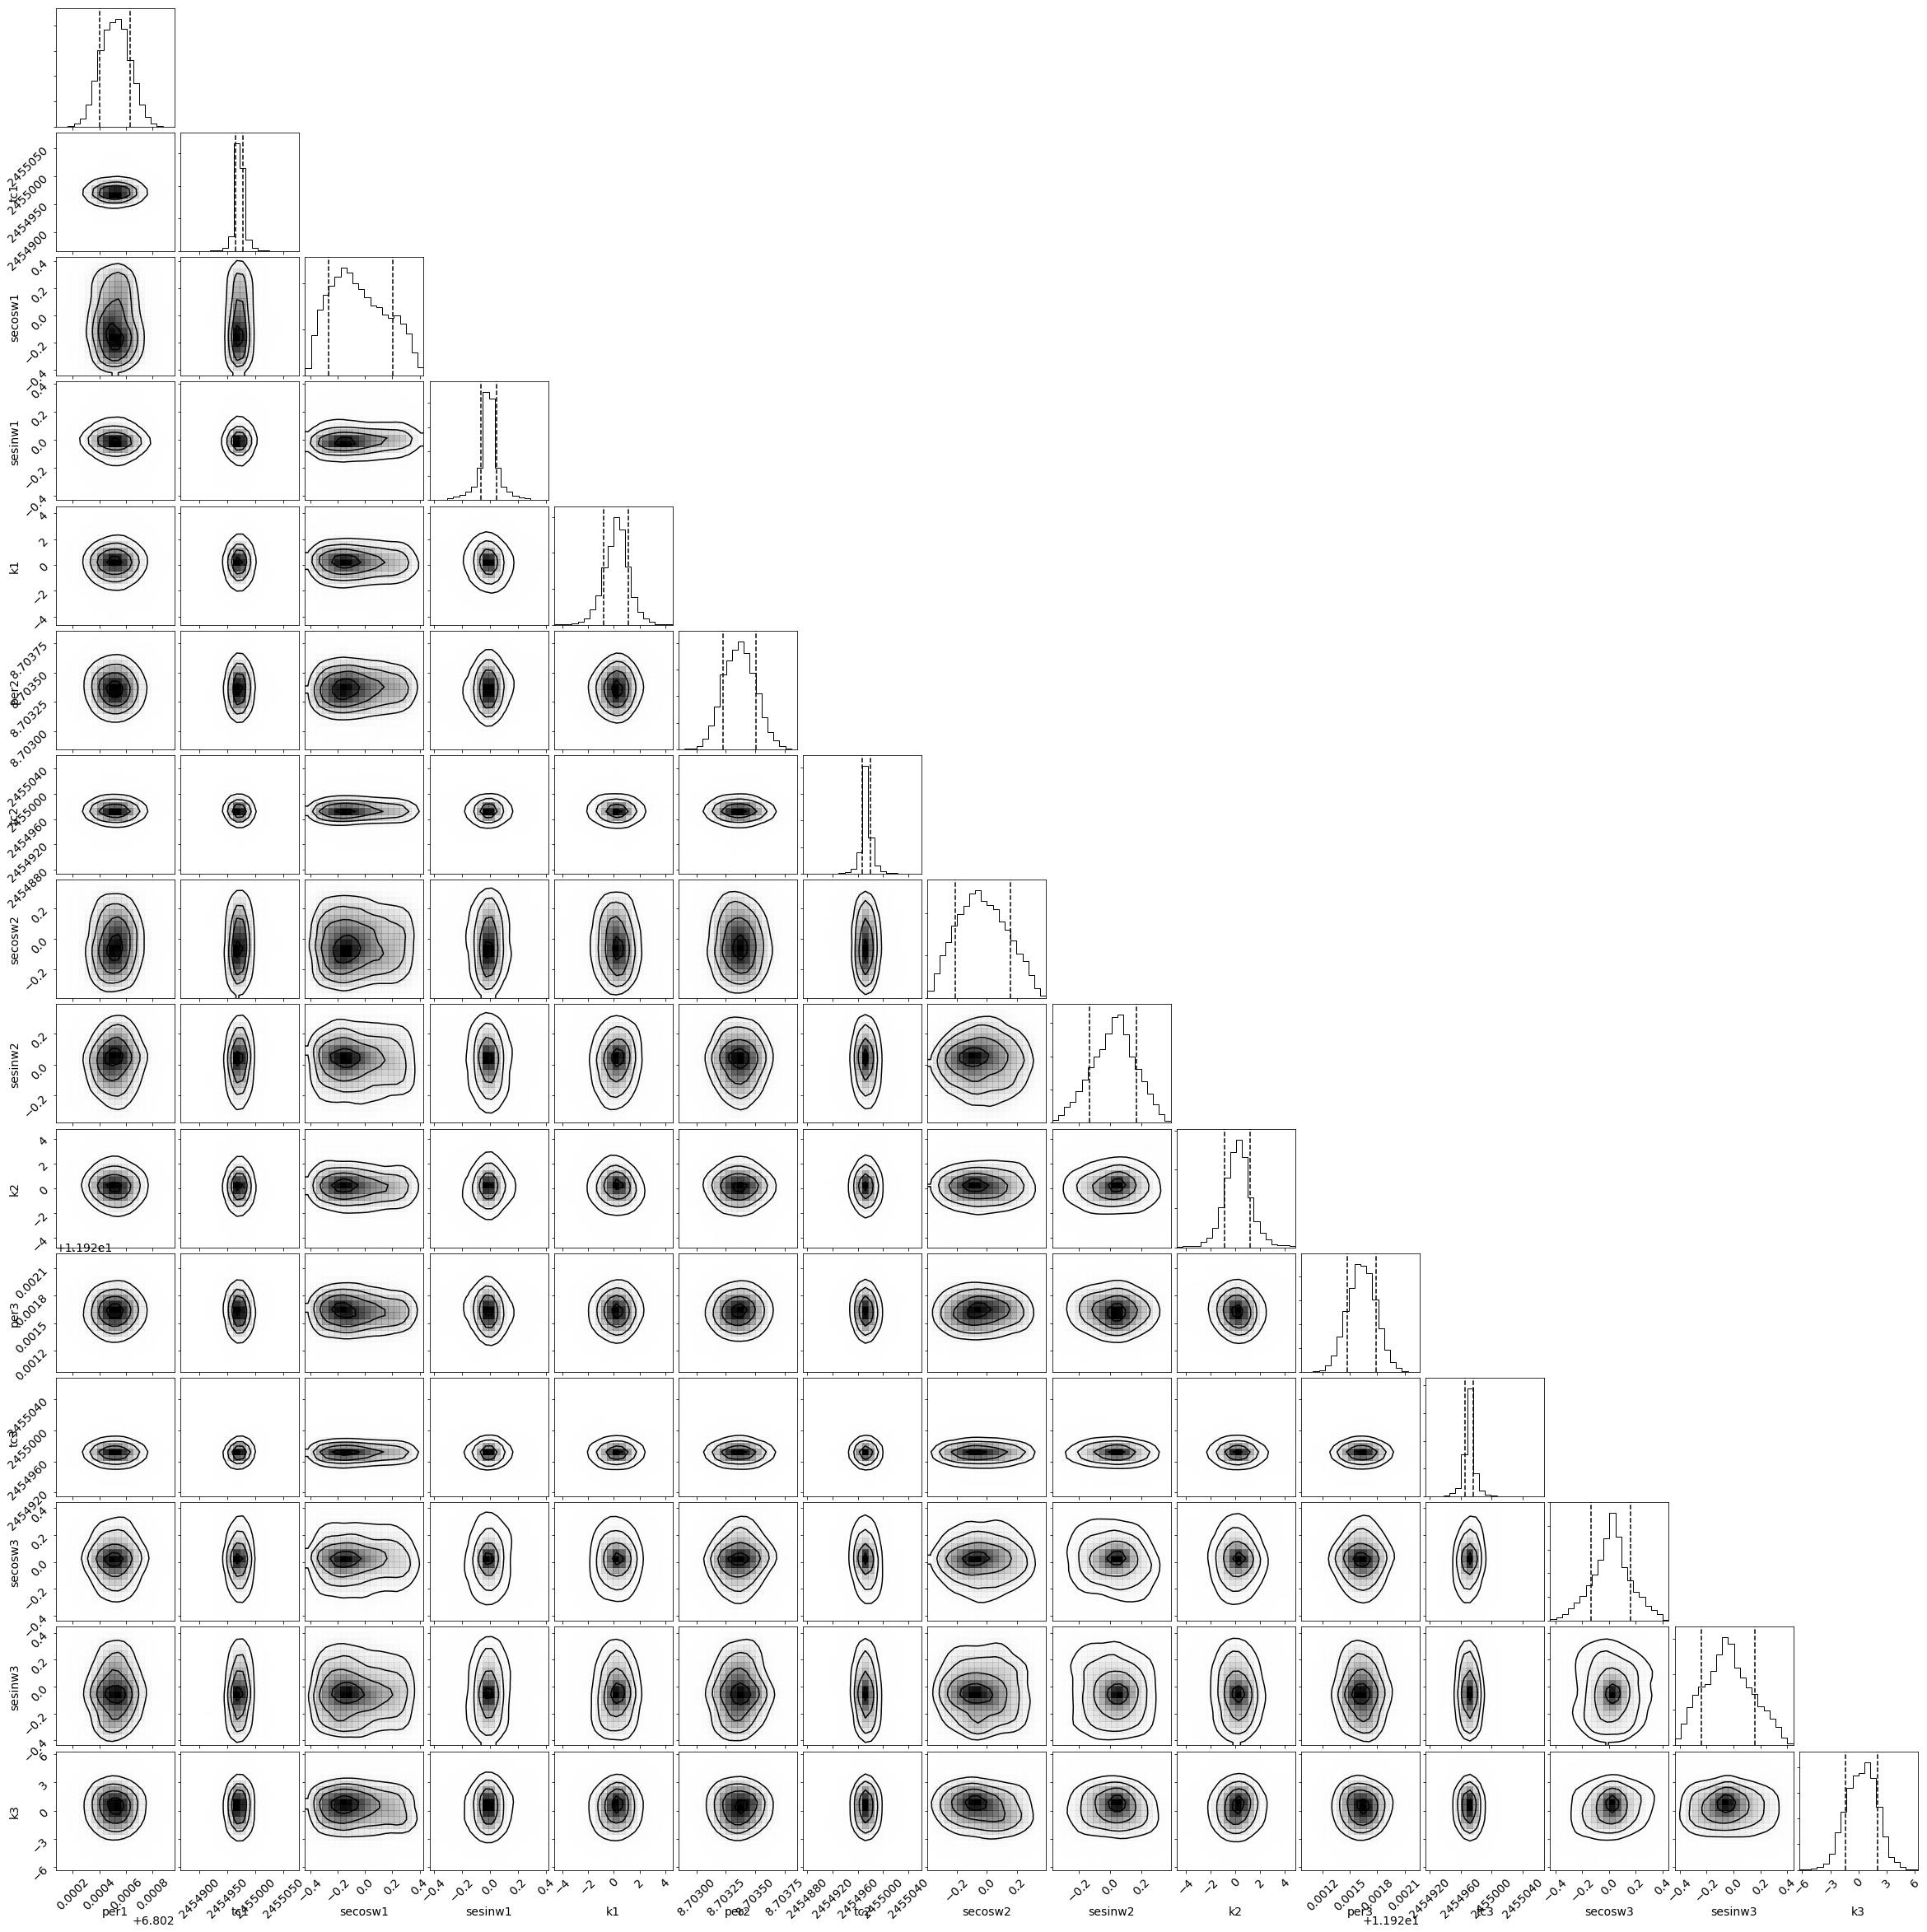

In [130]:
niter = len(df3)
labels = [k for k in post.params.keys() if post.params[k].vary]

fig = corner.corner(
    df3[labels],
    labels=labels,
    quantiles=[0.15,0.85],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )
# if use_stab:
#     plt.savefig("figs/corner_K431_stab_%d.png"%err_ind, bbox_inches="tight")
# else:
#     plt.savefig("figs/corner_K431_%d.png"%err_ind, bbox_inches="tight")

simulation archive: /storage/work/c/cjg66/Dan_research/Stability-Priors/output/K431/K431_start_10.bin
working on err_ind 0


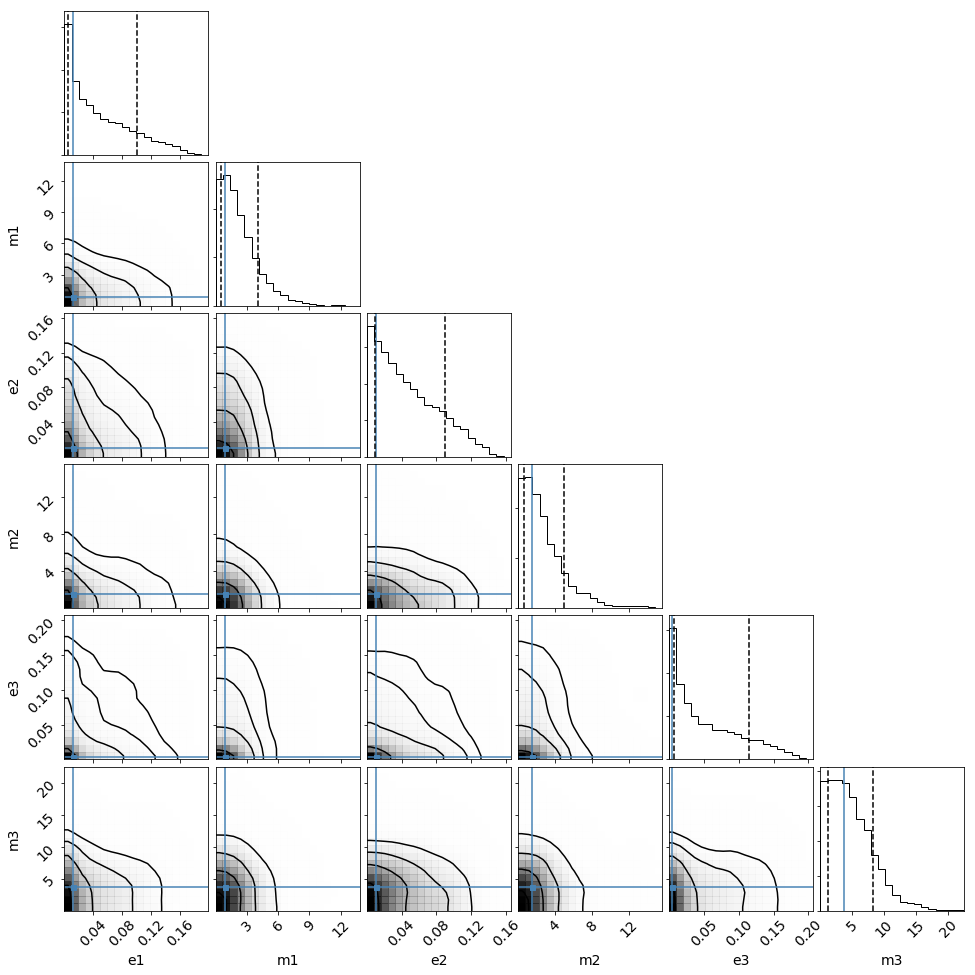

In [131]:
system = "K431"
out_dir = os.getcwd()+"/output/"+system+"/"
name = out_dir+system+"_start_"+str(sim_num)+".bin"

print("simulation archive:", name)
sim = rebound.SimulationArchive(name)[0]
# [].extend([sim.particles[i+1].e for i in range(3)])

# truths = []
# for i in range(3):
#     planet = sim.particles[i+1]
#     truths.append(sf.VSA(planet.P * sf.year_p_reboundtime, sim.particles[0].m, planet.m/sf.earth_mass_2_solar_mass, planet.e, planet.inc + np.pi/2))
truths = [sim.particles[i+1].e for i in range(3)]
truths2 = [sim.particles[i+1].m / earth_mass_2_solar_mass * np.cos(sim.particles[i+1].inc) for i in range(3)]

for index, item in enumerate(truths2):
    insert_index = index*2 + 1
    truths.insert(insert_index, item)

def prep_df(df2):
    df = df2.copy()
#     df = df.drop(columns="jit")
    df = df.drop(columns="lnprobability")
    for i in range(1,4):
        df["e%d"%i] = df["secosw%d"%i] * df["secosw%d"%i] + df["sesinw%d"%i] * df["sesinw%d"%i]
#         df["e%d"%i][df["e%d"%i] > 1] = 0
#         df["msini%d"%i] = sf.mass_from_VSA(df["per%d"%i] / days_p_year, Mstar, df["k%d"%i].abs(), df["e%d"%i], np.pi/2)
        df["m%d"%i] = sf.mass_from_VSA(df["per%d"%i] / days_p_year, Mstar, df["k%d"%i].abs(), df["e%d"%i], np.pi/2)
        df = df.drop(columns="k%d"%i)
        df = df.drop(columns="per%d"%i)
        df = df.drop(columns="tc%d"%i)
        df = df.drop(columns="secosw%d"%i)
        df = df.drop(columns="sesinw%d"%i)
#         df["k%d"%i] = 
    return df
    

print("working on err_ind %d"%err_ind)

df2 = prep_df(df3)

labels = list(df2.columns)
fig = corner.corner(
    df2,
    labels=labels,
    truths=truths,
    quantiles=[0.15,0.85],
    plot_datapoints=False,
    smooth=True,
    bins=20.
    )
# plt.savefig("figs/corner_K431_%d_small.png"%err_ind, bbox_inches="tight")

df2["m1+m2"] = df2["m1"] + df2["m2"]
df2["m2+m3"] = df2["m2"] + df2["m3"]
df2["total m"] = df2["m1"] + df2["m2"] + df2["m3"]

In [208]:
notebook_name = "K431_density_"
system_name = "K431 "

def create_hist2(label, show_quantiles=True, label2="", xlabel="", max_x=np.inf):
    if label2 == "":
        label2=label
    plt.figure(figsize=(8,4.5))
    n_bins=50
    plt.hist(df[label], density=True, bins=n_bins, alpha=0.6)
    plt.hist(df2[label][df2[label] < max_x], density=True, bins=n_bins, alpha=0.6)
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True)
    # plt.hist(df[label], n_bins, density=True, histtype='step', cumulative=True, weights=df["probstability"])
    plt.title(system_name + label2, size=30)
    plt.xlabel(xlabel, size=20)
    left, right = plt.xlim()  # return the current xlim
    left = 0
    right = np.minimum(right, max_x)
    plt.xlim(left, right)
    print()
    std1 = np.std(df[label])
    std2 = np.std(df2[label])
    print("std before: %f"%(std1))
    print("std after: %f"%(std2))
    print("factor of %f smaller"%(std1/std2))
    
    quant1 = np.quantile(df[label], 0.16)
    quant2 = np.quantile(df[label], 0.84)
    quant3 = np.quantile(df2[label], 0.16)
    quant4 = np.quantile(df2[label], 0.84)
    sigma1 = (quant2 - quant1) / 2
    sigma2 = (quant4 - quant3) / 2
    print("\"sigma\" before: %f"%(sigma1))
    print("\"sigma\" after: %f"%(sigma2))
    print("factor of %f smaller"%(sigma1/sigma2))
    if show_quantiles:
        plt.axvline(x=quant1, color="C0")
        plt.axvline(x=quant2, color="C0")
        plt.axvline(x=quant3, color="C1")
        plt.axvline(x=quant4, color="C1")
        
        kde = scipy.stats.gaussian_kde(df[label])
        xs = np.linspace(left, right, 1000)
        ys = kde(xs) + kde(-xs)
        popt1, pcov = curve_fit(gaussian, xs, ys, [0.3, 1, 3])
        print("Gaussian fit std before: ", popt1[2])
#         plt.plot(xs, ys, color="C0")
        plt.plot(xs, gaussian(xs, *popt1), color="C0")
        
        inds = np.sort(np.random.choice(range(len(df2)), size=5000, replace=False))
        kde = scipy.stats.gaussian_kde(df2[label][inds])
        ys = kde(xs) + kde(-xs)
        popt2, pcov = curve_fit(gaussian, xs, ys, [0.3, 1, 3])
        print("Gaussian fit std after: ", popt2[2])
#         plt.plot(xs, ys, color="C1")
        plt.plot(xs, gaussian(xs, *popt2), color="C1")
        
        print("factor of %f smaller"%(popt1[2]/popt2[2]))

    #     plt.savefig(notebook_name + label + "_hist.png", bbox_inches="tight")


std before: 1.749447
std after: 1.848775
factor of 0.946273 smaller
"sigma" before: 1.699540
"sigma" after: 1.689140
factor of 1.006157 smaller
Gaussian fit std before:  2.4535293215631766
Gaussian fit std after:  2.3588925957393654
factor of 1.040119 smaller

std before: 1.941765
std after: 2.396678
factor of 0.810190 smaller
"sigma" before: 1.719318
"sigma" after: 2.058749
factor of 0.835128 smaller
Gaussian fit std before:  2.864113352296288
Gaussian fit std after:  3.09895114544737
factor of 0.924220 smaller

std before: 3.102275
std after: 3.469911
factor of 0.894050 smaller
"sigma" before: 3.065462
"sigma" after: 3.391048
factor of 0.903986 smaller
Gaussian fit std before:  4.561752024086818
Gaussian fit std after:  5.018814517919614
factor of 0.908930 smaller


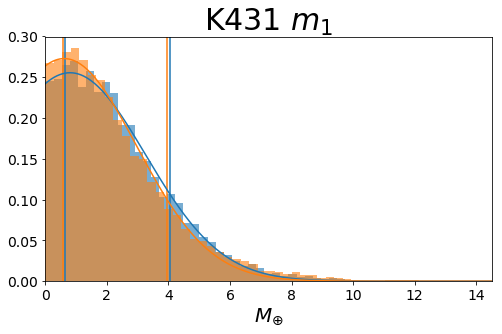

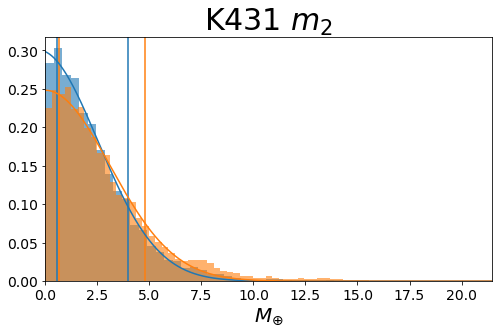

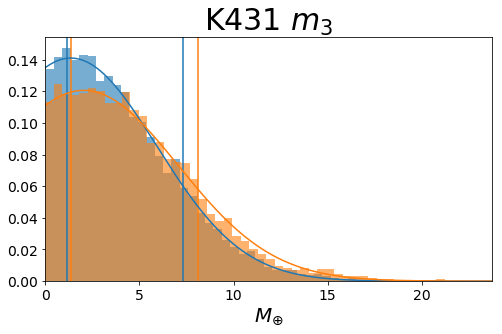

In [209]:
xs = np.linspace(0, 20, 1000)
create_hist2("m1", label2=r"$m_1$", xlabel=r"$M_{\oplus}$")
create_hist2("m2", label2=r"$m_2$", xlabel=r"$M_{\oplus}$")
create_hist2("m3", label2=r"$m_3$", xlabel=r"$M_{\oplus}$")


std before: 2.602214
std after: 3.056011
factor of 0.851507 smaller
"sigma" before: 2.476197
"sigma" after: 2.795400
factor of 0.885811 smaller
Gaussian fit std before:  2.489319602642248
Gaussian fit std after:  2.7900341407846825
factor of 0.892218 smaller

std before: 3.671563
std after: 4.222669
factor of 0.869489 smaller
"sigma" before: 3.615109
"sigma" after: 4.124975
factor of 0.876395 smaller
Gaussian fit std before:  3.75317734399907
Gaussian fit std after:  4.350824176767813
factor of 0.862636 smaller

std before: 4.039439
std after: 4.645260
factor of 0.869583 smaller
"sigma" before: 3.999332
"sigma" after: 4.513276
factor of 0.886126 smaller
Gaussian fit std before:  -3.987165224827879
Gaussian fit std after:  -4.452422625294862
factor of 0.895505 smaller


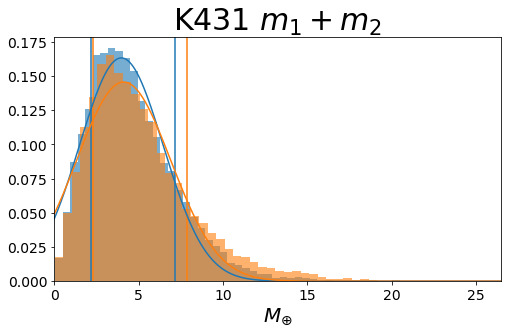

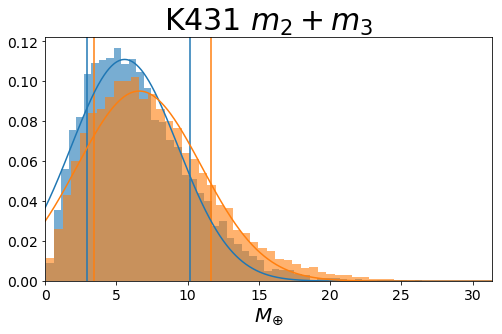

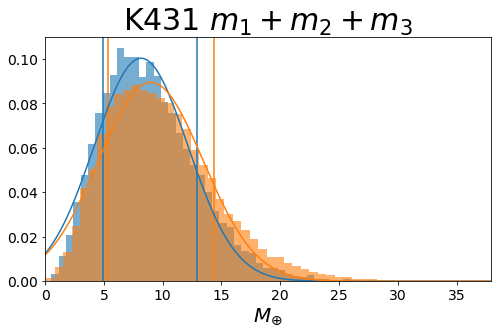

In [210]:
create_hist2("m1+m2", label2=r"$m_1 + m_2$", xlabel=r"$M_{\oplus}$")
create_hist2("m2+m3", label2=r"$m_2 + m_3$", xlabel=r"$M_{\oplus}$")
create_hist2("total m", label2=r"$m_1 + m_2 + m_3$", xlabel=r"$M_{\oplus}$")


std before: 0.042757
std after: 0.043207
factor of 0.989599 smaller
"sigma" before: 0.047195
"sigma" after: 0.045990
factor of 1.026201 smaller

std before: 0.033056
std after: 0.035448
factor of 0.932521 smaller
"sigma" before: 0.035163
"sigma" after: 0.038331
factor of 0.917335 smaller

std before: 0.046801
std after: 0.048542
factor of 0.964138 smaller
"sigma" before: 0.053053
"sigma" after: 0.051997
factor of 1.020315 smaller


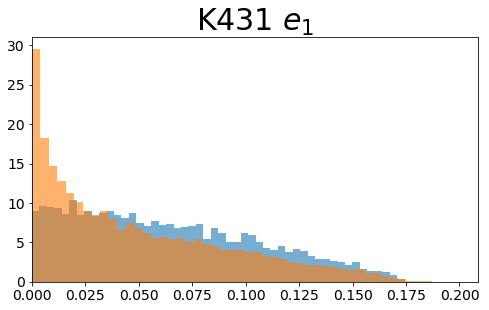

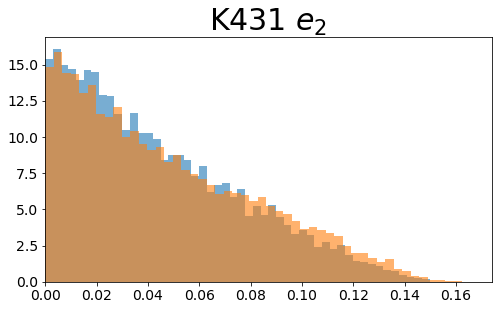

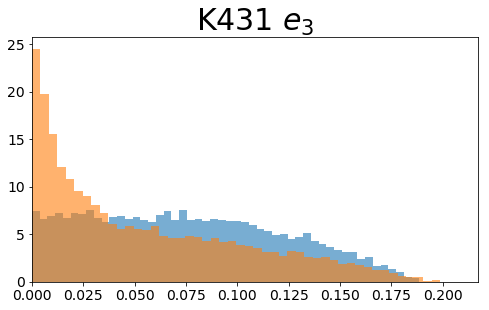

In [202]:
xs = np.linspace(0,1,1000)
create_hist2("e1", show_quantiles=False, label2=r"$e_1$")
# plt.plot(xs, prior_es[0](xs) + prior_es[0](-xs))
create_hist2("e2", show_quantiles=False, label2=r"$e_2$")
# plt.plot(xs, prior_es[1](xs) + prior_es[1](-xs))
create_hist2("e3", show_quantiles=False, label2=r"$e_3$")
# plt.plot(xs, prior_es[2](xs) + prior_es[2](-xs))